In [8]:
import os
import wave
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import IPython
from IPython import display
from jiwer import wer
from pydub import AudioSegment
from pydub.playback import play
import librosa
from scipy.io import wavfile
import random

# loading text files
df = pd.read_csv("Text/metadata_TZ_.csv")
print(df.dtypes)

df = df[['filename','transcription']]
df.head(5)

filename          object
transcription     object
filepath          object
sample_rate        int64
duration         float64
dtype: object


,filename,transcription
0,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,rais wa tanzania jakaya mrisho kikwete
1,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,yanayo andaliwa nami pendo pondo idhaa ya kisw...
2,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,inayokutangazia moja kwa moja kutoka jijini da...
3,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,juma hili bara la afrika limeshuhudia raia wa ...
4,SWH-05-20101106_16k-emission_swahili_05h30_-_0...,wakipiga kura ya maoni ilikufanya mabadiliko ya


In [4]:
split = int(len(df) * 0.8)
df_train_text = df[:split]
df_val_text = df[split:]

# df_train.describe
print(f"Size of the training set: {len(df_train_text)}")
print(f"Size of the testing set: {len(df_val_text)}")



Size of the training set: 8144
Size of the testing set: 2036


SETTING UP THE SWAHILI VOCABULARY TO INCLUDE IN THE MODEL

In [5]:
# The set of characters accepted in the transcription
char = [x for x in "aeioubcdghjklmnprstvwyz'?! "]

# Mapping characters to intergers
char_to_num = keras.layers.StringLookup(vocabulary=char, oov_token="")

# mapping intergers back to original characters 
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"size ={char_to_num.vocabulary_size()} "
)

The vocabulary is: ['', 'a', 'e', 'i', 'o', 'u', 'b', 'c', 'd', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'v', 'w', 'y', 'z', "'", '?', '!', ' '] size =28 


AUDIO DATA LOADING

In [6]:
# loading the audio files
# Directory
folder_path = 'D:/desktop/PyProjec/src/tz_swh_train/'


AUDIO PLAYBACK, FIRST 3 AUDIO FILES

In [9]:

audio_files = os.listdir(folder_path)
# Playing the first audio files
# Play the first three audio files
for i, swahili in enumerate(audio_files):
    audio_path = os.path.join(folder_path, swahili)
    if swahili.endswith(".wav") and i < 1:
        sound = os.path.join(folder_path, swahili)
IPython.display.Audio(sound, rate=16000)

AUDIO PROCESSING VIA TENSORFLOW

In [10]:
# An integer scalar Tensor. The window length in samples
frame_length = 256
# An integer scalar Tensor. The number of samples to step
frame_step = 160
# An integer scalar Tensor. the size of the FFT to apply
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ####################################
    ###    Audio processing for tensorflow 
    ####################################
    # 1. Read wav files
    file = tf.io.read_file(folder_path + wav_file + '.wav')
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    
    audio = tf.squeeze(audio, axis=-1)
    # change the file type to float
    audio = tf.cast(audio, tf.float32)
    
    spectogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # we only need the magnitude, which can be derived by applying tf.abs
    spectogram = tf.abs(spectogram)
    spectogram = tf.math.pow(spectogram, 0.5)
    # normalization
    means = tf.math.reduce_mean(spectogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectogram, 1, keepdims=True)
    spectogram = (spectogram - means) / (stddevs + 1e-10)


    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)
    return spectogram, label


SPLITTING THE TRAIN AND TEST SET FOR MODEL TRAINING AND TESTING USING TENSORFLOW

In [11]:
batch_size = 32
# Define the training dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train_text['filename']), list(df_train_text['transcription']))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val_text['filename']), list(df_val_text['transcription']))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 193), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>


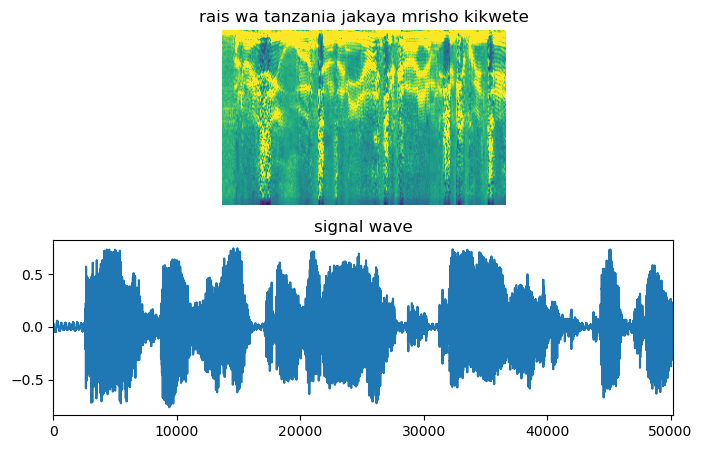

In [12]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
   print(train_dataset)
   spectogram = batch[0][0].numpy()
   spectogram = np.array([np.trim_zeros(x) for x in np.transpose(spectogram)])
   label = batch[1][0]
   # spectogram
   label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
   ax = plt.subplot(2, 1, 1)
   ax.imshow(spectogram, vmax=1)
   ax.set_title(label)
   ax.axis("off")
   # wav
   file = tf.io.read_file(folder_path + list(df_train_text['filename'])[0] + ".wav")
   audio, _ = tf.audio.decode_wav(file)
   audio = audio.numpy()
   ax = plt.subplot(2, 1, 2)
   plt.plot(audio)
   ax.set_title("signal wave")
   ax.set_xlim(0, len(audio))
   display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

CTCLOSS detection algorithmn

In [13]:
def CTCLoss(y_true, y_pred):
   batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
   input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
   label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

   input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
   label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

   loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
   return loss

Model Build

In [14]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=138):

   input_spectogram = layers.Input((None, input_dim), name="input")

   x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectogram)

   x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 41],
      strides=[2, 2],
      padding="same",
      use_bias=False,
      name="conv_1",
   )(x)
   x = layers.BatchNormalization(name="conv_1_bn")(x)
   x = layers.ReLU(name="conv_1_relu")(x)

   x = layers.Conv2D(
      filters=32,
      kernel_size=[11, 21],
      strides=[1, 2],
      padding="same",
      use_bias=False,
      name="conv_2",
   )(x)
   x = layers.BatchNormalization(name="conv_2_bn")(x)
   x = layers.ReLU(name="conv_2_relu")(x)
   x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

   for i in range(1, rnn_layers + 1):
      recurrent = layers.GRU(
         units=rnn_units,
         activation="tanh",
         recurrent_activation="sigmoid",
         use_bias=True,
         return_sequences=True,
         reset_after=True,
         name=f"gru_{i}",
      )
      x = layers.Bidirectional(
         recurrent, name=f"bidirectional_{i}", merge_mode="concat"
      )(x)
      if i < rnn_layers:
         x = layers.Dropout(rate=0.5)(x)
   x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
   x = layers.ReLU(name="dense_1_relu")(x)
   x = layers.Dropout(rate=0.5)(x)

   output = layers.Dense(units=output_dim + 1, activation="softmax")(x)

   model = keras.Model(input_spectogram, output, name="DeepSpeech_2")

   opt = keras.optimizers.Adam(learning_rate=1e-4)

   model.compile(optimizer=opt, loss=CTCLoss)
   return model


# get the model
model = build_model(
   input_dim = fft_length // 2 + 1,
   output_dim = char_to_num.vocabulary_size(),
   rnn_units = 512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

Training and Evaluation

In [ ]:
def decode_batch_predictions(pred, input_shape):
   input_len = np.ones(pred.shape[0]) * input_shape[1]
   results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
   output_text = []
   for result in results:
      result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
      output_text.append(result)
   return output_text

class CallbackEval(keras.callbacks.Callback):

   def __init__(self, dataset):
      super().__init__()
      self.dataset = dataset
   
   def on_epoch_end(self, epoch: int, logs=None):
      predictions = []
      targets = []
      for batch in self.dataset:
         X, y = batch
         batch_predictions = model.predict(X)
         batch_predictions = decode_batch_predictions(batch_predictions, X.shape)
         predictions.extend(batch_predictions)
         for label in y:
            label = (
               tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            )
            targets.append(label)
      wer_score = wer(targets, predictions)
      print("-" * 100)
      print(f"word error rate: {wer_score: 4f}")
      print("-" * 100)
      for i in np.random.randint(0, len(predictions), 2):
         print(f"Target :  {targets[i]}")
         print(f"Prediction: {predictions[i]}")
         print("-" * 100)

Begin Training Sequence

In [ ]:
# Define the number of epochs.
epochs = 2
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
   train_dataset,
   validation_data=validation_dataset,
   epochs=epochs,
   callbacks=[validation_callback],
)

Inference

In [ ]:
predictions = []
targets = []
for batch in test_dataset:
   X, y = batch
   batch_predictions = model.predict(X)
   batch_predictions = decode_batch_predictions(batch_predictions)
   predictions.extend(batch_predictions)
   for label in y:
      label = tf.strings.reduce_join(num_to_char(label)).numpy.decode("utf-8")
      targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print("word error rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
   print(f"Target :  {targets[i]}")
   print(f"Prediction:  {predictions[i]}")
   print("-" * 100)